# Notes importantes

1. KMeans<br>

KMeans est un algorithme regroupant les données en essayant de séparer les échantillons en n groupes de variance égale, en minimisant un critère connu sous le nom d'inertie ou de somme de carrés dans le groupe (voir ci-dessous). Cet algorithme nécessite que le nombre de clusters soit spécifié.

In [71]:
# Importation des librairies
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Étape 1: Chargement du dataset

In [72]:
dataset = pd.read_csv("./Fichiers de données/UNSW_NB15_training-set.csv")

In [73]:
dataset

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0


# Étape 2: Prétraitement des données

In [74]:
# Nature des données
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [75]:
# import numpy as np
# df_numeric = dat2.select_dtypes(include=[np.number])
# df_numeric.describe(include='all')

In [76]:
# Nettoyage des données
dataset.drop_duplicates(inplace=True)
dataset.dropna(inplace=True)

In [77]:
# Normalisation des données numériques
scaler = StandardScaler()
numeric_features = dataset.select_dtypes(include=['float64', 'int64']).columns
dataset[numeric_features] = scaler.fit_transform(dataset[numeric_features])

In [78]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  float64
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  float64
 6   dpkts              82332 non-null  float64
 7   sbytes             82332 non-null  float64
 8   dbytes             82332 non-null  float64
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  float64
 11  dttl               82332 non-null  float64
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  float64
 15  dloss              82332 non-null  float64
 16  sinpkt             823

# Etape 3: Sélection des caractéristiques pertinentes

In [79]:
# Selection aléatoire de 10000 données dans le dataset
dataset = dataset.sample(n=10000, random_state=42)

In [80]:
selected_features = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean']
X = dataset[selected_features]

# Étape 4: Clustering hiérarchique

In [81]:
# Choix du nombre de clusters
model = AgglomerativeClustering(n_clusters= 3,linkage='complete')

In [82]:
pred_model = model.fit_predict(X)

# Étape 5: Calcul du score de silhouette

In [83]:
print("Score de silhouette: ", silhouette_score(X, pred_model))

Score de silhouette:  0.948049286556037


# Étape 6: Visualisation des clusters avec un dendrogramme

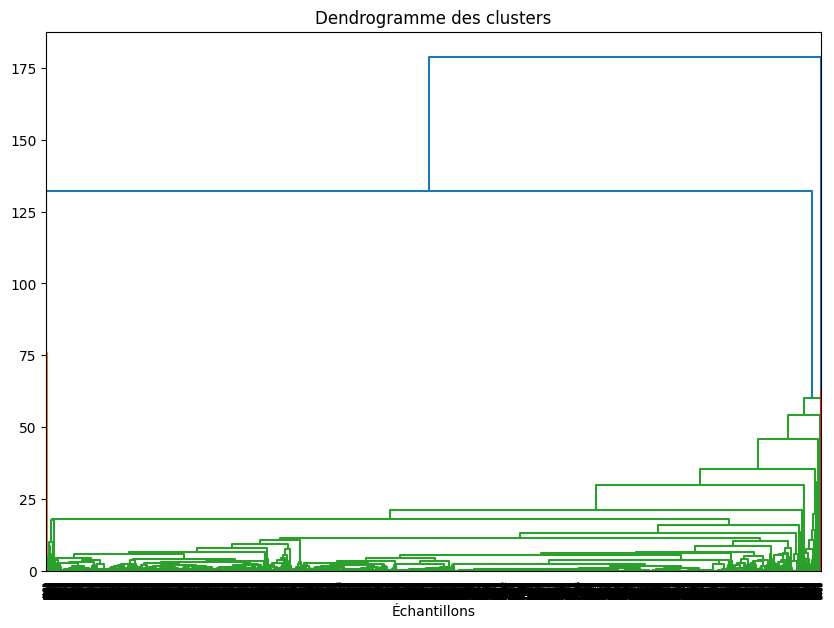

In [84]:
# Calcul du dendrogramme pour visualiser la structure hiérarchique des clusters
linked = linkage(X, method='complete', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(linked,distance_sort='descending')
plt.title('Dendrogramme des clusters')
plt.xlabel('Échantillons')
plt.show()

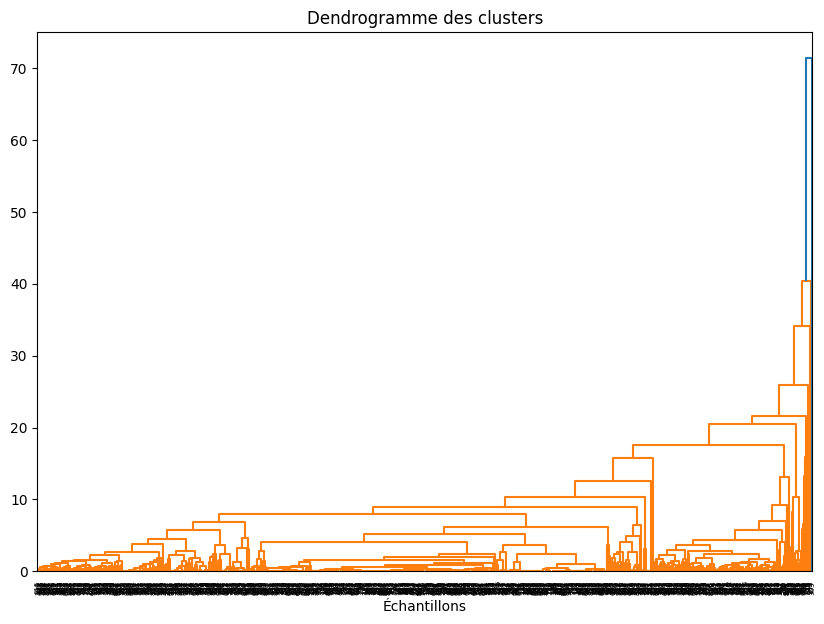

In [85]:
# Calcul du dendrogramme pour visualiser la structure hiérarchique de 3 clusters avec 1000
dataset2 = dataset.sample(n=1000, random_state=42)
X2 = dataset2[selected_features]
linked = linkage(X2, method='complete', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(linked,distance_sort='descending')
plt.title('Dendrogramme des clusters')
plt.xlabel('Échantillons')
plt.show()

In [86]:
# Identification des anomalies
distances = pairwise_distances(dataset[numeric_features])
avg_distances = distances.mean(axis=1)
anomalies_indices = avg_distances.argsort()[-10:][::-1]  # 10 indices des anomalies avec les distances les plus élevées
anomalies = dataset.iloc[anomalies_indices]

print("Anomalies détectées :")
print(anomalies)

Anomalies détectées :
             id        dur proto service state      spkts      dpkts  \
81046  1.677964  12.040728   tcp    http   FIN   0.009958  -0.013376   
9342  -1.338967  12.514788   tcp    smtp   CON  69.994367  12.065529   
63917  0.957265   8.685961   tcp       -   FIN  50.788232   8.742965   
64504  0.981962   8.778201   tcp       -   FIN  41.170230   7.315301   
9506  -1.332067   8.892542   tcp    smtp   FIN  40.348816   6.925938   
64138  0.966563   6.584397   tcp       -   FIN  -0.004977   0.003929   
43814  0.111435  12.494613   tcp    smtp   CON  30.715879   5.749196   
446   -1.713264   7.255147   tcp    smtp   FIN  30.805488   5.230046   
1169  -1.682844  12.522594   tcp    smtp   CON  27.370487   5.333876   
51381  0.429815   2.820365   tcp    http   FIN   3.191067  25.191389   

          sbytes     dbytes      rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  \
81046  -0.036914  -0.071471 -0.554505  ...         -0.450186       -0.390391   
9342   72.781894   0.3162